In [1]:
import os
import pickle

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

/var/folders/xw/h6mw3gd53ng1606cw8xws09r0000gn/T/ipykernel_54479/3583080115.py:5: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
2024-02-20 20:18:44.707741: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
# load data
DATA_PATH = "/Users/musatai/masters/research/code/fl-demo/databases/raw_data"
DATA_FILE = "cardio_train.csv"

data_df = pd.read_csv(os.path.join(DATA_PATH, DATA_FILE), delimiter=";")

In [10]:
data_df.shape

(70000, 13)

In [11]:
test_data = data_df.sample(frac=0.2, random_state=1)
test_data.shape

(14000, 13)

In [12]:
test_data = test_data.drop("id", axis=1)
test_data["age"] = test_data["age"] // 365
test_data['bmi'] = test_data['weight'] / (test_data['height'] / 100) ** 2
test_data = test_data.drop(["height", "weight"], axis=1)
test_data = test_data[~((test_data["ap_hi"] > 250) | (test_data["ap_lo"] > 200))]
test_data = test_data[~((test_data["ap_hi"] < 60) | (test_data["ap_lo"] < 60))]

In [13]:
target = test_data["cardio"]
test_data = test_data.drop("cardio", axis=1)

In [14]:
scaler = StandardScaler()
features = scaler.fit_transform(test_data)

In [16]:
features.shape

(13724, 10)

# Centralized Model

In [18]:
with open("/Users/musatai/masters/research/code/fl-demo/databases/centralized_model/centralized_model.pickle", "rb") as fp:
    centralized_model = pickle.load(fp)

In [19]:
centralized_loss, cetralized_accuracy = centralized_model.evaluate(features, target)

429/429 [==============================] - 1s 756us/step - loss: 0.5645 - accuracy: 0.7282


In [20]:
cetralized_accuracy

0.728213369846344

In [21]:
centralized_loss

0.5644513964653015

# Federated Model

In [54]:
with open("/Users/musatai/masters/research/code/fl-demo/databases/global_models/2024-02-21-00-27-52-global_model.pickle", "rb") as fp:
    federated_model = pickle.load(fp)

In [55]:
federated_model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

In [56]:
federated_loss, federated_accuracy = federated_model.evaluate(features, target)

429/429 [==============================] - 0s 692us/step - loss: 0.5674 - accuracy: 0.7291


In [57]:
federated_accuracy

0.7290877103805542

In [58]:
federated_loss

0.5674400329589844

# Comparing The Learning Curve

In [61]:
history = []

for client_id in [1, 2, 3, 4]:
    with open(f"../databases/train_history/client_{client_id}/history.pickle", "rb") as fp:
        history.append(pickle.load(fp))

with open(f"../databases/train_history/centralized/history.pickle", "rb") as fp:
    history.append(pickle.load(fp))


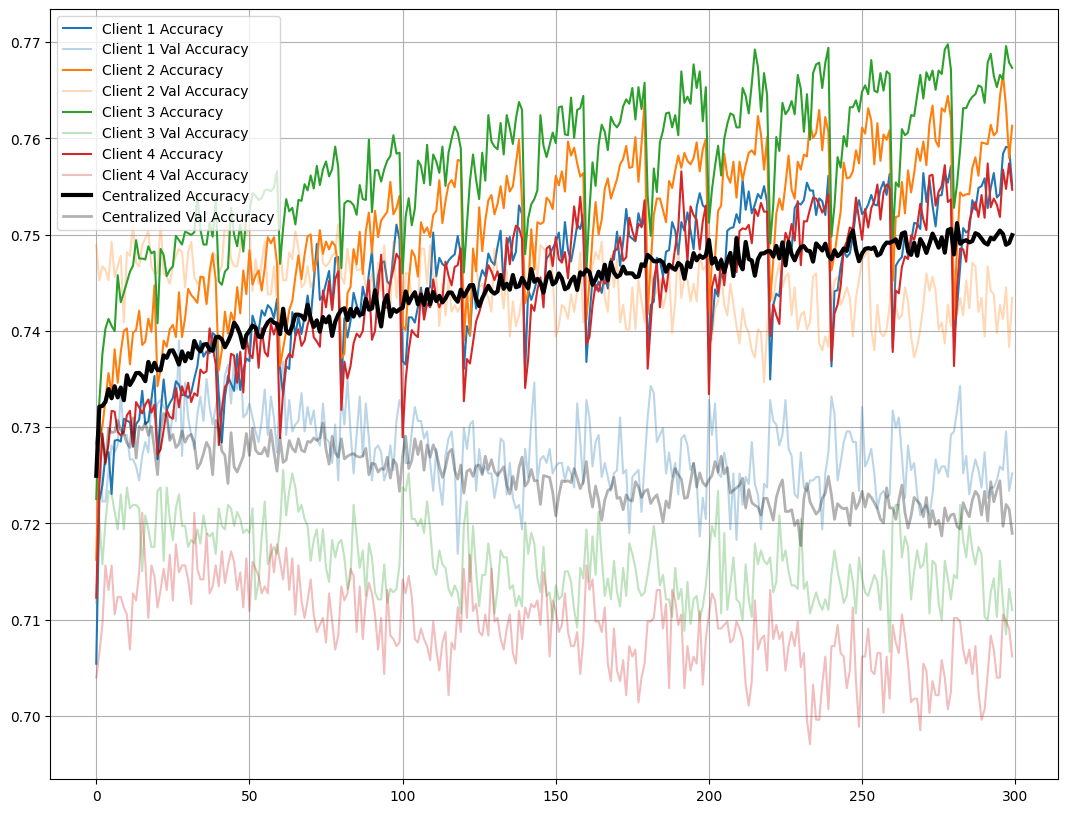

In [62]:
plt.figure(figsize=(13, 10))
plt.grid()
COLORS = ["blue", "orange", "green", "red"]

for client_id in range(len(history) - 1):
    plt.plot(history[client_id]["accuracy"], color=f"tab:{COLORS[client_id]}", label=f"Client {client_id + 1} Accuracy")
    plt.plot(history[client_id]["val_accuracy"], color=f"tab:{COLORS[client_id]}", alpha=0.3, label=f"Client {client_id + 1} Val Accuracy")


plt.plot(history[-1]["accuracy"], color="black", linewidth=3, label="Centralized Accuracy")
plt.plot(history[-1]["val_accuracy"], color="black", linewidth=2, label="Centralized Val Accuracy", alpha=0.3)

plt.legend()